<a href="https://colab.research.google.com/github/Davidportlouis/100daysofcode/blob/master/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import numpy as np
from PIL import Image
from torch import nn,optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torch.utils.data.sampler import SubsetRandomSampler
from helper import plot_batch,train,test,predict,predict_image

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

--2020-06-26 07:36:40--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip.1’

Cat_Dog_data.zip.1  100%[===================>] 553.60M  14.5MB/s    in 41s     

2020-06-26 07:37:23 (13.4 MB/s) - ‘Cat_Dog_data.zip.1’ saved [580495262/580495262]



In [ ]:
!unzip Cat_Dog_data.zip
!rm Cat_Dog_data.zip

In [58]:
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(200),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5,0.5,0.5],
                       std=[0.5,0.5,0.5])
])

test_transform = transforms.Compose([
  transforms.RandomResizedCrop(200),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5,0.5,0.5],
                       std=[0.5,0.5,0.5])
])

train_data = datasets.ImageFolder("./Cat_Dog_data/train/",transform=train_transform)
test_data = datasets.ImageFolder("./Cat_Dog_data/test/",transform=test_transform)

train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

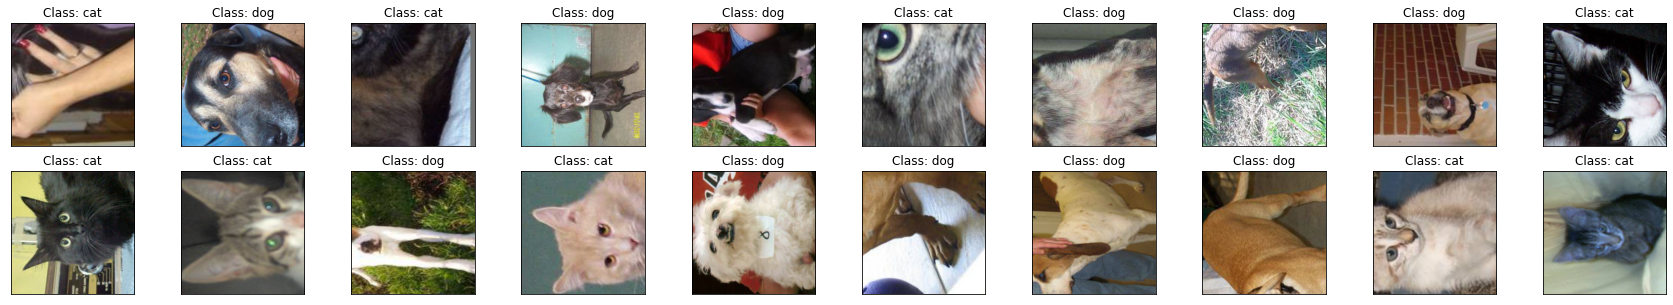

In [59]:
train_images,train_labels = next(iter(train_loader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [60]:
class ConvNet(nn.Module):
  def __init__(self,conv_dim=32):
    super(ConvNet,self).__init__()

    # layers definition
    self.conv_1 = nn.Conv2d(3,conv_dim,3,stride=1,padding=1)
    self.conv_2 = nn.Conv2d(conv_dim,conv_dim*2,3,stride=1,padding=1)
    self.maxpool = nn.MaxPool2d(2,2)
    self.drop = nn.Dropout(0.2)
    self.fc1 = nn.Linear(50*50*conv_dim*2,512)
    self.out = nn.Linear(512,2)

  def forward(self,x):
    x = F.relu(self.conv_1(x))
    x = self.maxpool(x)
    x = F.relu(self.conv_2(x))
    x = self.maxpool(x)
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = self.out(x)
    return x
  
model = ConvNet()
model = model.to(device)
print(model)

ConvNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=160000, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
train_loss,valid_loss = train(model,train_loader,valid_loader,optimizer,criterion,50,device)

epoch: 1/50 trainloss: 0.66564 validloss: 0.61787 time: 128.962 sec
Loss decresed: inf -> 0.61787
epoch: 2/50 trainloss: 0.61871 validloss: 0.59813 time: 129.490 sec
Loss decresed: 0.61787 -> 0.59813
epoch: 3/50 trainloss: 0.59161 validloss: 0.57788 time: 129.665 sec
Loss decresed: 0.59813 -> 0.57788
epoch: 4/50 trainloss: 0.57474 validloss: 0.54223 time: 128.022 sec
Loss decresed: 0.57788 -> 0.54223
epoch: 5/50 trainloss: 0.55491 validloss: 0.56490 time: 130.031 sec
epoch: 6/50 trainloss: 0.55547 validloss: 0.55405 time: 128.241 sec
epoch: 7/50 trainloss: 0.53639 validloss: 0.50459 time: 129.190 sec
Loss decresed: 0.54223 -> 0.50459
epoch: 8/50 trainloss: 0.53580 validloss: 0.50329 time: 129.949 sec
Loss decresed: 0.50459 -> 0.50329
epoch: 9/50 trainloss: 0.51399 validloss: 0.49869 time: 129.022 sec
Loss decresed: 0.50329 -> 0.49869
epoch: 10/50 trainloss: 0.51295 validloss: 0.50534 time: 127.847 sec
epoch: 11/50 trainloss: 0.50214 validloss: 0.49979 time: 129.353 sec
epoch: 12/50 tra

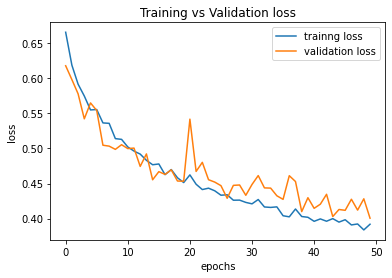

In [62]:
plt.plot(train_loss,label="trainng loss")
plt.plot(valid_loss,label="validation loss")
plt.title("Training vs Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [63]:
state_dict = torch.load("model_weights.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [64]:
test(model,test_loader,optimizer,criterion,device)

testloss: 0.427419 accuracy: 0.805


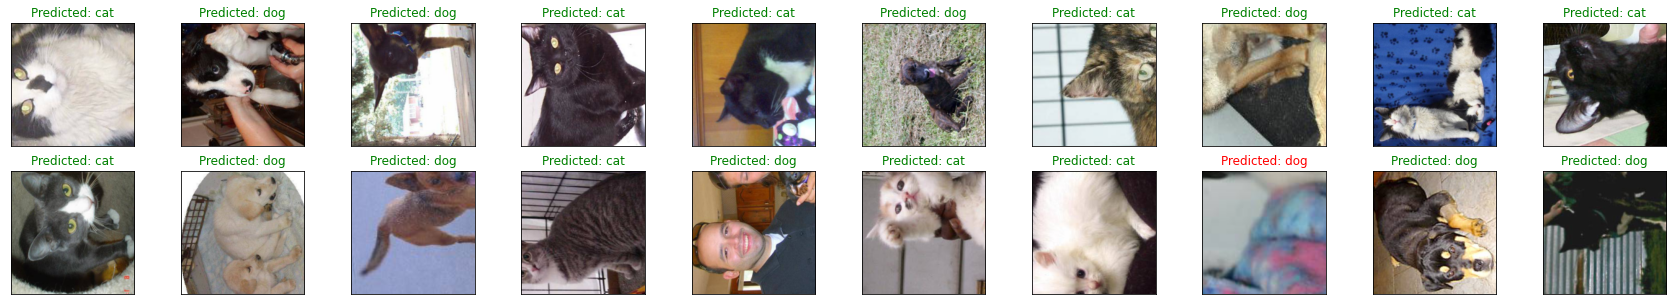

In [77]:
test_images,test_labels = next(iter(test_loader))
predict(test_images,classes,test_labels,model,device)

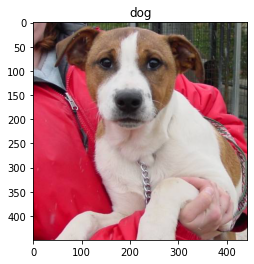

In [78]:
img = "test_1.jpg"
predict_image(img,model,test_transform,device,classes)

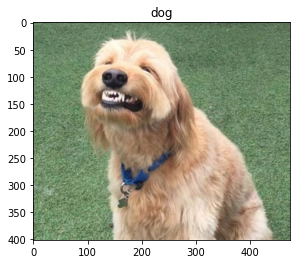

In [80]:
img2 = "test_2.jpeg"
predict_image(img2,model,test_transform,device,classes)

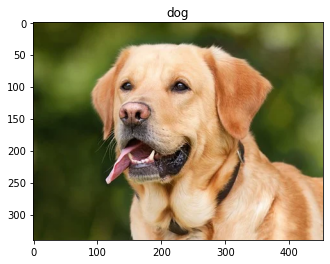

In [67]:
img3 = "test1.jpeg"
predict_image(img3,model,test_transform,device,classes)

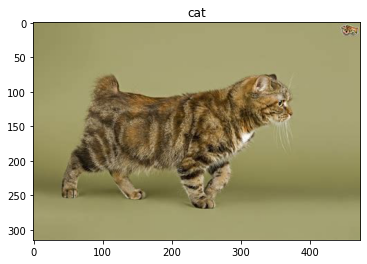

In [81]:
img4 = "test_4.jpeg"
predict_image(img4,model,test_transform,device,classes)

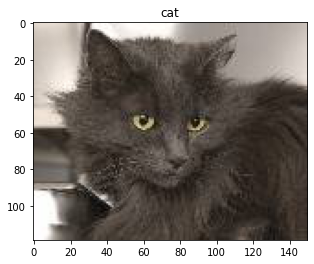

In [83]:
img5 = "test_8.jpg"
predict_image(img5,model,test_transform,device,classes)